# Option Pricing: Black-Scholes, Heston, and Merton
## Overall Objective: Understand and compare three fundamental option pricing models.

<div style="border-left: 4px solid #2196F3; padding-left: 15px;">
    
**1. Black-Scholes: The benchmark model assuming constant volatility.**  
_Provides a great baseline and is computationally efficient, but assumes constant $\sigma$ which is unrealistic for modern markets._
</div>

<span style="color:gray; opacity: 0.5;">**2. Heston:** Adds stochastic volatility (volatility clustering and mean reversion).</span>  
    <span style="color:gray; opacity: 0.5;">_Captures the "Smirk" or "Skew" via stochastic vol—essential for pricing OTM puts accurately._</span>
    
<span style="color:gray; opacity: 0.5;">**3. Merton Jump:** Adds "jumps" to the asset price to model market shocks.</span>  
    <span style="color:gray; opacity: 0.5;">_Captures "Fat Tails" and sudden crashes via Poisson jumps._</span>


## 1. Black-Scholes Model

The Black-Scholes model assumes the stock price $S_t$ follows a Geometric Brownian Motion (GBM):$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

We can deconstruct this engine into two distinct components:
* **The Deterministic Drift ($\mu S_t dt$):** This represents the expected, constant growth rate of the asset. If market volatility were zero, the stock would simply grow smoothly at rate $\mu$, compounding like money in a standard savings account.
  
* **The Stochastic Diffusion ($\sigma S_t dW_t$):** This injects the randomness. $dW_t$ is a Wiener process (Standard Brownian Motion) representing unpredictable market shocks. By scaling this randomness by the current stock price ($S_t$), the model ensures that the asset price can never drop below zero, perfectly reflecting the reality of limited liability in equities.
Where:   
- $\mu$ is the drift.  
- $\sigma$ is the constant volatility.  
- $dW_t$ is a Wiener process (Brownian motion). 
<br>

**Call Option Formula**  
The price of a European Call option $C(S, t)$ is given by:  
$$C(S, t) = S_0 e^{-qT} N(d_1) - K e^{-rT} N(d_2)$$
<br>
Where $N(\cdot)$ is the cumulative distribution function of the standard normal distribution, and:  
$$d_1 = \frac{\ln(S_0/K) + (r - q + \sigma^2/2)T}{\sigma\sqrt{T}}$$$$d_2 = d_1 - \sigma\sqrt{T}$$  

###
**Volatility Drag (The Asymmetry of Returns):**  
Because asset returns compound geometrically, downward price movements penalize the overall value more severely than upward movements of the exact same percentage. A 50% drop requires a 100% gain just to recover the initial capital. 

Mathematically, this "volatility drag" manifests when we apply Ito's Lemma to the log-return process, introducing a $-\frac{1}{2}\sigma^2$ variance penalty term. The higher the volatility, the stronger this downward drag on the expected geometric return.

## Imports and Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
from scipy.integrate import quad
import seaborn as sns

# Set plotting style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Global Parameters (Toggles)
S0 = 100.0    # Spot Price
K_list = np.linspace(80, 120, 50) # Range of Strikes for plotting
T = 1.0       # Time to Maturity (1 year)
r = 0.05      # Risk-free rate
q = 0.0       # Dividend yield

## Simulating Black-Scholes

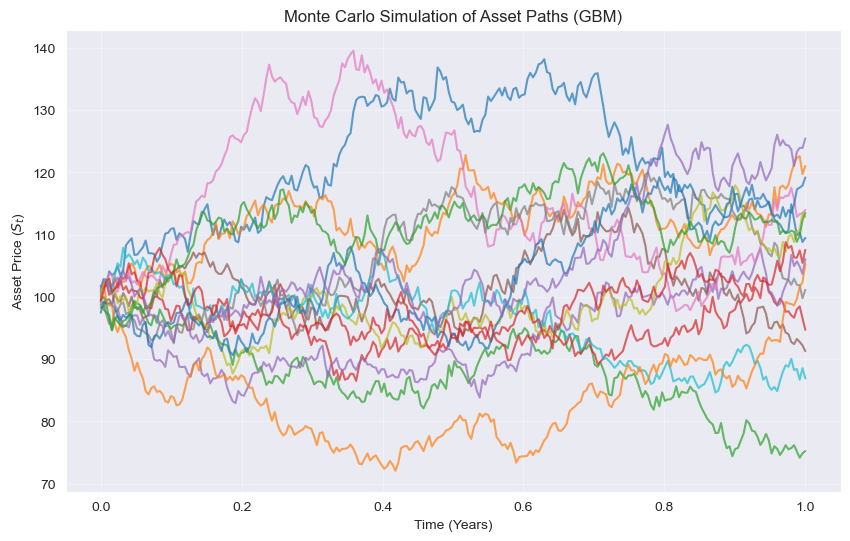

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Simulate Geometric Brownian Motion (GBM) ---
def simulate_gbm(S0, mu, sigma, T, dt, num_paths):
    """
    Simulates asset price paths using Geometric Brownian Motion.
    """
    N = int(T / dt) # Number of time steps
    t = np.linspace(0, T, N)
    
    # Generate random Wiener process steps
    W = np.random.standard_normal(size=(num_paths, N)) 
    W = np.cumsum(W, axis=1) * np.sqrt(dt) 
    
    # Calculate the paths using the analytical solution to the GBM SDE
    # Notice the volatility drag term: (mu - 0.5 * sigma^2)
    X = (mu - 0.5 * sigma**2) * t + sigma * W 
    S = S0 * np.exp(X) 
    return t, S

# Parameters for simulation
S0_sim = 100      # Initial stock price
mu_sim = 0.08     # Expected return (drift)
sigma_sim = 0.20  # Volatility
T_sim = 1.0       # Time horizon (1 year)
dt_sim = 1/252    # Daily steps
num_paths = 15    # Number of simulated paths to plot

t_steps, paths = simulate_gbm(S0_sim, mu_sim, sigma_sim, T_sim, dt_sim, num_paths)

plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(t_steps, paths[i, :], lw=1.5, alpha=0.7)
    
plt.title('Monte Carlo Simulation of Asset Paths (GBM)')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price ($S_t$)')
plt.grid(True, alpha=0.3)
plt.show()

In [1]:
# --- 2. Black-Scholes Call Pricing & The Greeks ---

def d1(S, K, T, r, q, sigma):
    return (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

def d2(S, K, T, r, q, sigma):
    return d1(S, K, T, r, q, sigma) - sigma * np.sqrt(T)

def bs_call_price(S, K, T, r, q, sigma):
    if sigma <= 0 or T <= 0: return max(S * np.exp(-q * T) - K * np.exp(-r * T), 0)
    return (S * np.exp(-q * T) * si.norm.cdf(d1(S, K, T, r, q, sigma)) - 
            K * np.exp(-r * T) * si.norm.cdf(d2(S, K, T, r, q, sigma)))

def bs_call_delta(S, K, T, r, q, sigma):
    """Rate of change of option price with respect to underlying asset."""
    return np.exp(-q * T) * si.norm.cdf(d1(S, K, T, r, q, sigma))

def bs_gamma(S, K, T, r, q, sigma):
    """Rate of change of Delta (convexity). Identical for calls and puts."""
    return (np.exp(-q * T) * si.norm.pdf(d1(S, K, T, r, q, sigma))) / (S * sigma * np.sqrt(T))

def bs_vega(S, K, T, r, q, sigma):
    """Sensitivity to volatility. Identical for calls and puts."""
    return S * np.exp(-q * T) * si.norm.pdf(d1(S, K, T, r, q, sigma)) * np.sqrt(T)

def bs_call_theta(S, K, T, r, q, sigma):
    """Time decay of the option."""
    term1 = -(S * np.exp(-q * T) * si.norm.pdf(d1(S, K, T, r, q, sigma)) * sigma) / (2 * np.sqrt(T))
    term2 = r * K * np.exp(-r * T) * si.norm.cdf(d2(S, K, T, r, q, sigma))
    term3 = q * S * np.exp(-q * T) * si.norm.cdf(d1(S, K, T, r, q, sigma))
    return term1 - term2 + term3

# Let's visualize Delta across different underlying prices
S_range = np.linspace(50, 150, 100)
K_fixed = 100
T_fixed = 1.0
r_fixed = 0.05
q_fixed = 0.0
sigma_fixed = 0.2

deltas = [bs_call_delta(S, K_fixed, T_fixed, r_fixed, q_fixed, sigma_fixed) for S in S_range]

plt.figure(figsize=(8, 5))
plt.plot(S_range, deltas, color='purple', lw=2)
plt.axvline(x=K_fixed, color='black', linestyle='--', label='Strike Price (K=100)')
plt.title('Call Option Delta vs. Underlying Price')
plt.xlabel('Underlying Price ($S_t$)')
plt.ylabel('Delta ($\Delta$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'np' is not defined

## 3. The Options Pricing Surface

Options pricing is inherently multi-dimensional. The price is not just a function of the underlying asset's price, but also its strike price and the time remaining until expiration. 

By calculating the Black-Scholes price across a grid of different strikes and maturities, we can generate a 3D pricing surface. This visualizes how Out-Of-The-Money (OTM) options lose value rapidly as expiration approaches, while In-The-Money (ITM) options converge exactly to their intrinsic payoff.

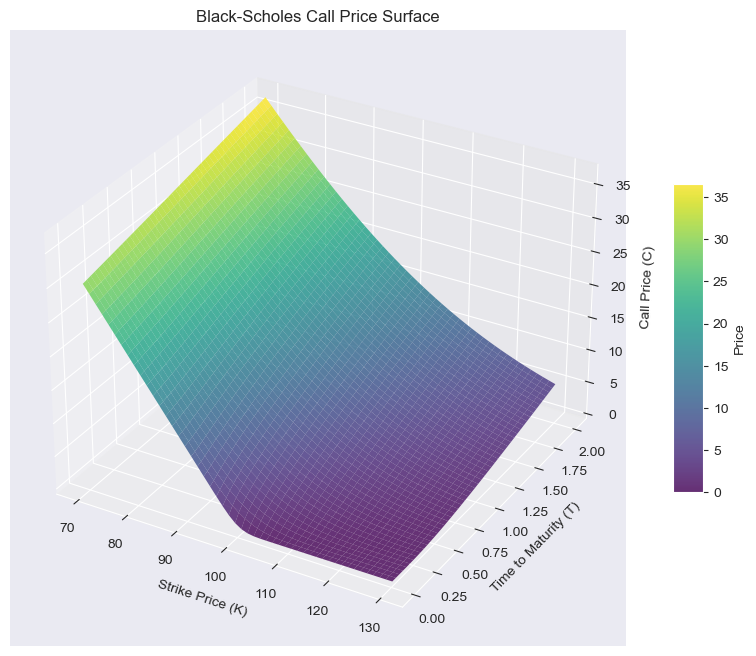

In [11]:
# --- 3. 3D Surface Plot of Option Prices ---

# Create a meshgrid for Time to Maturity (T) and Strike Price (K)
T_surf = np.linspace(0.01, 2.0, 50) # Avoid exactly 0 to prevent division by zero
K_surf = np.linspace(70, 130, 50)
T_mesh, K_mesh = np.meshgrid(T_surf, K_surf)

# Calculate prices over the grid
Prices_mesh = np.zeros_like(T_mesh)
for i in range(T_mesh.shape[0]):
    for j in range(T_mesh.shape[1]):
        # Keeping Underlying S=100 fixed
        Prices_mesh[i, j] = bs_call_price(100, K_mesh[i, j], T_mesh[i, j], r_fixed, q_fixed, sigma_fixed)

# Plotting the surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(K_mesh, T_mesh, Prices_mesh, cmap='viridis', edgecolor='none', alpha=0.8)

ax.set_title('Black-Scholes Call Price Surface')
ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Call Price (C)')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Price')
plt.show()